In [1]:
import numpy as np
import pandas as pd

import rasterio

from sklearn.cluster import KMeans, MiniBatchKMeans

from scipy.ndimage import zoom

import matplotlib.pyplot as plt
import cartopy
from cartopy import crs as ccrs

import glob

def process_image(filename):

    img = rasterio.open(filename)

    img_array = img.read()

    shape = img_array.shape

    reshaped_img = img_array.reshape(img_array.shape[0], -1).T

    return img_array, reshaped_img, shape

def cluster_image(data, img_shape, n_clusters=2, use_mini_batch=False):

    if use_mini_batch:

        model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)

    else:

        model = KMeans(n_clusters=n_clusters, random_state=42)

    model.fit(data)

    clustered = model.labels_

    # Majoritary class is 0
    if np.sum(clustered==0) < np.sum(clustered==1):

        clustered = 1 - clustered

    clustered = clustered.reshape(img_shape[1], img_shape[2])

    return clustered

In [ ]:
filename = "Horshoe_bend_images/horshoe_bend_07_2019.jpg"

img, data, shape = process_image(filename)

clustered_image = cluster_image(data, shape, n_clusters=2, use_mini_batch=True)

# Load PCF data plot
filename = "horshoe_bend_07_2019_coords.csv"

df_pcf_img = pd.read_csv(filename)

filename_sim = "big_system/P_58.008530460617.txt"

data = np.loadtxt(filename_sim)

xs = data[0, :]
ys = data[1, :]

df_pcf_sim = pd.read_csv("big_system_pcf.csv")

/home/alex/.conda/envs/GEO/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/alex/.conda/envs/GEO/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
df_pcf_sim = pd.read_csv("big_system_pcf.csv")

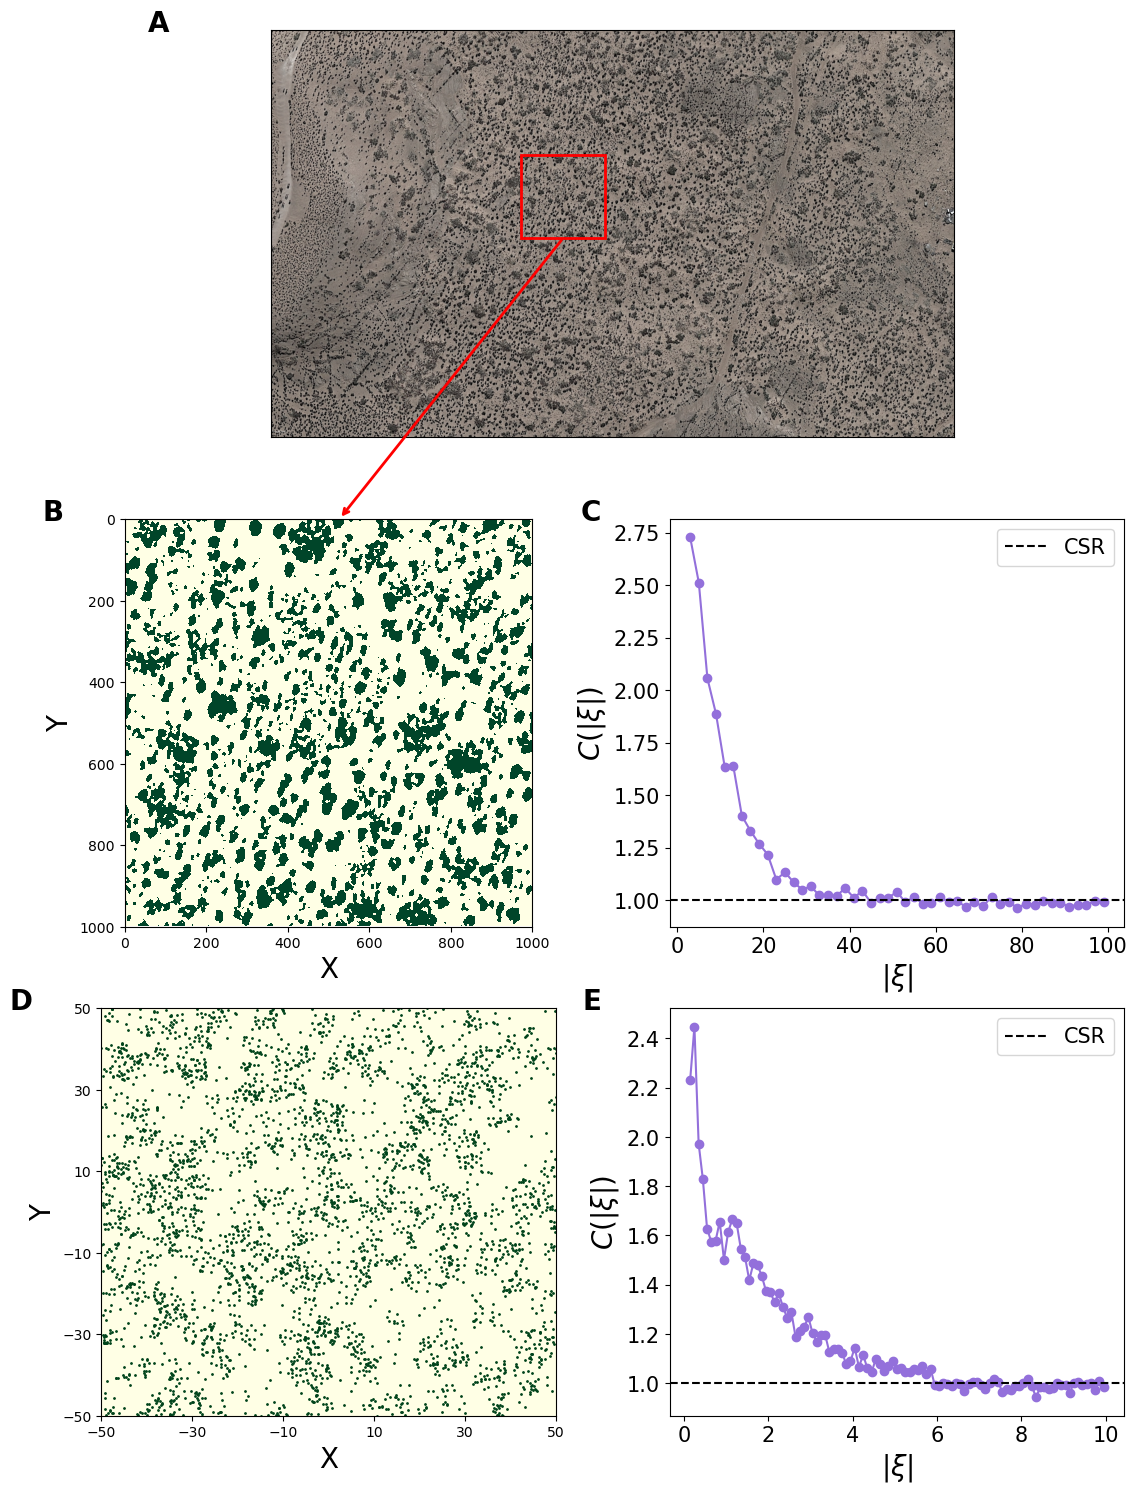

In [77]:
# Plot
fig, ax = plt.subplot_mosaic(
    """
    AA
    BC
    DE
    """,
    figsize=(6.6*2, 6*3),
    gridspec_kw={"wspace":0.25}
)

ax["A"].imshow(np.moveaxis(img, 0, -1))
ax["A"].set_xticks([])
ax["A"].set_yticks([])

ax["A"].add_patch(plt.Rectangle((3000, 1500), 1000, 1000, edgecolor="red", facecolor="none", lw=2))

# Draw an arrow from the rectangle to the ax["A"]
ax["A"].annotate("", xy=(3500, 2500), xytext=(0.1, -0.2), xycoords="data", textcoords="axes fraction",
                arrowprops=dict(arrowstyle="<-", color="red", lw=2))

cmap = plt.get_cmap("YlGn", 2)

ax["B"].imshow(clustered_image[1500:2500, 3000:4000], cmap=cmap)

ax["B"].set_xticks(np.arange(0, 1001, 200))
ax["B"].set_yticks(np.arange(0, 1001, 200))

ax["B"].set_xlabel("X", fontsize=20)
ax["B"].set_ylabel("Y", fontsize=20)

ax["C"].plot(df_pcf_img["r"][1:], df_pcf_img["g"][1:], marker="o", color="mediumpurple")
ax["C"].axhline(1.0, color="k", linestyle="--", label="CSR")

ax["C"].set_xlabel(r"$\left|\xi\right|$", fontsize=20)
ax["C"].set_ylabel(r"$C(\left|\xi\right|)$", fontsize=20)

ax["C"].tick_params(axis='both', which='major', labelsize=15)

ax["C"].legend(fontsize=15)

ax["D"].scatter(xs, ys, s=1, color="#00441b")

ax["D"].set_facecolor("#ffffe5")

ax["D"].set_xlabel("X", fontsize=20)
ax["D"].set_ylabel("Y", fontsize=20)

ax["D"].set_xticks(np.arange(-50, 51, 20))
ax["D"].set_yticks(np.arange(-50, 51, 20))

ax["D"].set_xlim(-50, 50)
ax["D"].set_ylim(-50, 50)

ax["E"].plot(df_pcf_sim["r"][1:], df_pcf_sim["g"][1:], marker="o", color="mediumpurple")

ax["E"].axhline(1.0, color="k", linestyle="--", label="CSR")

ax["E"].set_xlabel(r"$\left|\xi\right|$", fontsize=20)
ax["E"].set_ylabel(r"$C(\left|\xi\right|)$", fontsize=20)

ax["E"].tick_params(axis="both", which="major", labelsize=15)

ax["E"].legend(fontsize=15)

# Label all subplots
for label, axis in ax.items():
    axis.text(
        -0.15, 
        1.05,
        label,
        transform=axis.transAxes,
        fontsize=20,
        fontweight='bold',
        va='top',
        ha='right'
    )

plt.savefig("horseshoe_bend_pcf.png", dpi=300, bbox_inches="tight")

# Save all image cuts

In [ ]:
filenames = glob.glob("Horshoe_bend_images/*.jpg")

for filename in filenames:

    if filename.endswith(".jpg"):
        
        name = filename.split("/")[-1].split(".")[0]

        img, data, shape = process_image(filename)

        clustered_image = cluster_image(data, shape, n_clusters=2, use_mini_batch=True)

        clustered_image_sample = clustered_image[1500:2500, 3000:4000]

        # Save data as txt with coordinates
        # coords = np.column_stack(np.where(clustered_image == 1))
        coords = np.column_stack(np.where(clustered_image_sample == 1))

        np.savetxt(f"coordinates/{name}_coords_sample.txt", coords, fmt="%d", header="y x", comments='')
        